# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the navigation task. This task has been taken from Udacity-Deep-Reinforcement-Learning Nanodegree. The algorithm you will be implementing is **REINFORCE** to achieve the task.

(https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name='Banana_Linux/Banana.x86_64',no_graphics=True) #put path to environment file

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

from agent import Agent

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
agent = Agent(state_size, action_size, 42)

In [6]:
def update_policy(agent, rewards, log_probs, gamma):
    discounted_rewards = []
    for t in range(len(rewards)):
        Gt = 0 
        pw = 0
        for r in rewards[t:]:
            Gt = Gt + gamma**pw * r
            pw = pw + 1
        discounted_rewards.append(Gt)

    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9) # normalize discounted rewards

    experiences = (log_probs, discounted_rewards)
    agent.learn(experiences)
    
def play_episode(agent, env, T_max):
    env_info = env.reset(train_mode=True)[brain_name]
    state = env_info.vector_observations[0]
    rewards = []
    log_probs = []

    for t in range(T_max):
        action, log_prob = agent.act(state)
        log_probs.append(log_prob)
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0] 
        rewards.append(reward)
        done = env_info.local_done[0]
        if done:
            break
        state = next_state
    
    return rewards, log_probs
        

In [7]:
def REINFORCE(num_episodes=5000, T_max=1000, gamma=0.92):

    scores = []
    last100_scores = deque(maxlen=100)  
    
    for i in range(1, num_episodes+1):
#         rewards, log_probs = play_episode(agent, env, T_max)
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        rewards = []
        log_probs = []
        
        for t in range(T_max):
            action, log_prob = agent.act(state)
            log_probs.append(log_prob)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0] 
            rewards.append(reward)
            done = env_info.local_done[0]
            if done:
                break
            state = next_state
        
        S = sum(rewards)
        last100_scores.append(S)
        scores.append(S)

        update_policy(agent, rewards, log_probs, gamma)
        
        if i < 100:
            continue
        
        if i % 50 == 0:
            print('Episode {}: Average Score (last 100 episodes): {:.3f}'.format(i, np.mean(last100_scores)))
        if np.mean(last100_scores)>=13.0:
            print('Environment solved in {:d} episodes\nAverage Score (last 100 episodes): {:.3f}'.format(i, np.mean(last100_scores)))
            break
        
    return scores

In [8]:
scores = REINFORCE()

Episode 100: Average Score (last 100 episodes): 0.220
Episode 150: Average Score (last 100 episodes): 0.240
Episode 200: Average Score (last 100 episodes): 0.930
Episode 250: Average Score (last 100 episodes): 2.270
Episode 300: Average Score (last 100 episodes): 4.730
Episode 350: Average Score (last 100 episodes): 8.110
Episode 400: Average Score (last 100 episodes): 10.750
Episode 450: Average Score (last 100 episodes): 11.770
Episode 500: Average Score (last 100 episodes): 11.940
Episode 550: Average Score (last 100 episodes): 11.810
Episode 600: Average Score (last 100 episodes): 11.390
Episode 650: Average Score (last 100 episodes): 11.770
Episode 700: Average Score (last 100 episodes): 11.950
Episode 750: Average Score (last 100 episodes): 12.120
Episode 800: Average Score (last 100 episodes): 12.890
Episode 850: Average Score (last 100 episodes): 12.500
Episode 900: Average Score (last 100 episodes): 12.100
Episode 950: Average Score (last 100 episodes): 11.990
Episode 1000: Av

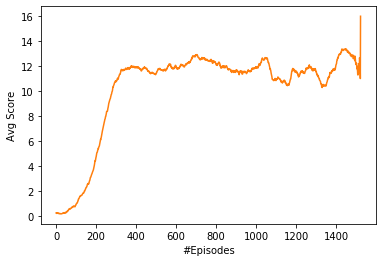

In [23]:
average_scores = [np.mean(scores[i:i+100]) for i in range(0, len(scores)+1, 1)]
# average_scores.append(np.mean(scores[-100:]))
plt.plot(15)
plt.plot(average_scores)
plt.xlabel('#Episodes')
plt.ylabel('Avg Score')
plt.show()

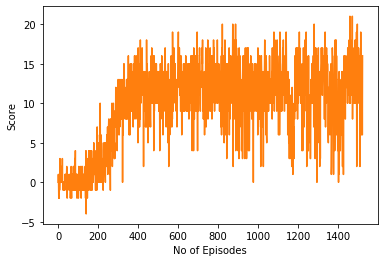

In [19]:
plt.plot(15)
plt.plot(scores)
plt.xlabel('No of Episodes')
plt.ylabel('Score')
plt.show()

In [20]:
env.close()